In [1]:
import numpy as np 
import pandas as pd

from plotly import graph_objs as go
import plotly.express as px

import warnings
warnings.filterwarnings( 'ignore' )

train_ds = pd.read_csv( './datasets/titanic_train.csv' )
test_ds = pd.read_csv( './datasets/titanic_test.csv' )
answers = pd.read_csv( './datasets/gender_submission.csv' )

In [2]:
ds = pd.merge( answers, test_ds, on = 'PassengerId', how = 'outer' )
link = [ train_ds, ds ]
ds = pd.concat( link, ignore_index = True )


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [4]:
ds.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
ds['Age'].fillna( value = ds['Age'].median(), inplace = True )

In [6]:
ds['Age'].round(0)
ds['Age'] = ds['Age'].astype( int )

In [7]:
ds[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()['Survived']

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = ds[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()['Age'],
        y = ds[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()['Survived']
))

fig.show()


In [8]:
ds.loc[ ds['Age'] <= 10, 'Age'] = 0
ds.loc[ ( ds['Age'] > 10 ) & ( ds['Age'] <= 18 ), 'Age'] = 1
ds.loc[ ( ds['Age'] > 18 ) & ( ds['Age'] <= 46 ), 'Age'] = 2
ds.loc[ ( ds['Age'] > 46 ) & ( ds['Age'] <= 64 ), 'Age'] = 3
ds.loc[ ds['Age'] > 64, 'Age'] = 4


In [9]:
ds['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [10]:
ds['Embarked'].fillna( value = 'S', inplace = True )

In [11]:
ds['Embarked'] = ds['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [12]:
ds['Fare'].fillna( value = ds['Fare'].median(), inplace = True )

In [13]:
ds['Sex'] = ds['Sex'].map( {'female': 1, 'male': 0} ).astype( int )

In [14]:
ds['Title'] = ds.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [15]:
ds['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [16]:
ds['Title'] = ds['Title'].replace(['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
     
ds['Title'] = ds['Title'].replace('Mlle', 'Miss')
ds['Title'] = ds['Title'].replace('Ms', 'Miss')
ds['Title'] = ds['Title'].replace('Mme', 'Mrs')

In [17]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
ds['Title'] = ds['Title'].map(title_mapping)
ds['Title'] = ds['Title'].fillna(0)

In [18]:
ds['FamilySize'] = ds['SibSp'] + ds['Parch'] + 1

In [19]:
ds['IsAlone'] = 0
ds.loc[ ds['FamilySize'] == 1, 'IsAlone'] = 1

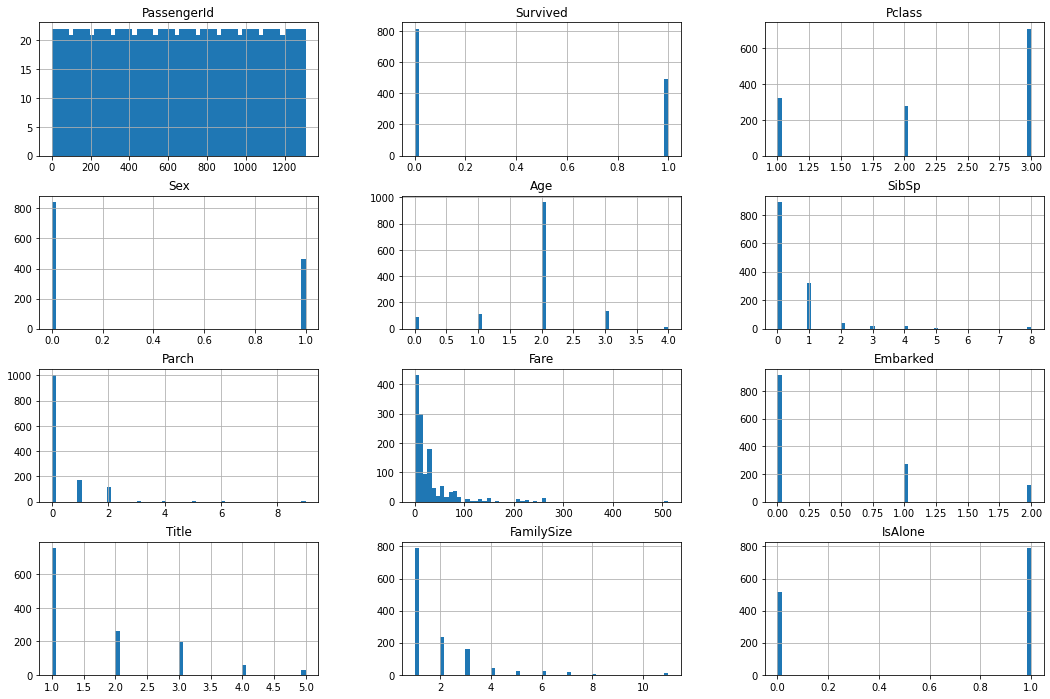

In [20]:
import matplotlib.pyplot as plt

ds.hist(bins = 60, figsize = ( 18, 12 ))
plt.show()

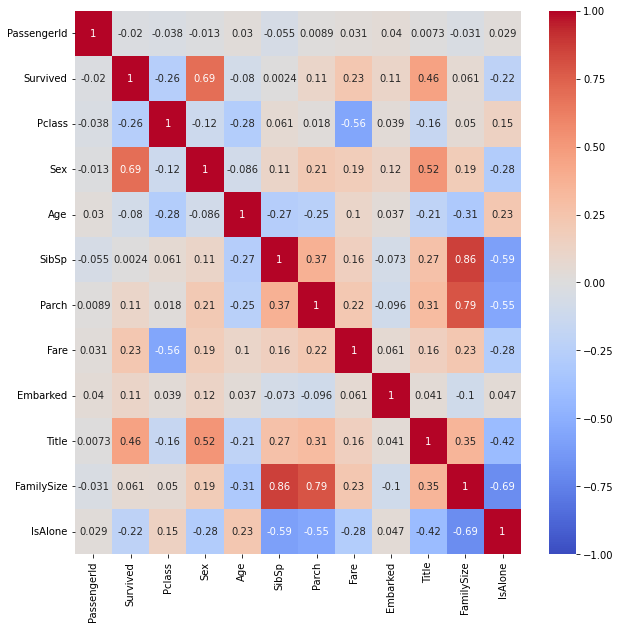

In [21]:
import seaborn as sns

corr_matrix = ds.corr()
ax, fig = plt.subplots(figsize = ( 10, 10 ))
sns.heatmap(corr_matrix, vmin = -1, cmap = 'coolwarm', annot = True)
plt.show()

In [22]:
corr_matrix[ abs(corr_matrix['Survived']) > 0.1 ]['Survived'].sort_values()

Pclass     -0.264710
IsAlone    -0.216299
Parch       0.108919
Embarked    0.111625
Fare        0.233773
Title       0.456723
Sex         0.688371
Survived    1.000000
Name: Survived, dtype: float64

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

x = ds[[ 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'IsAlone' ]]
y = ds.iloc[ :, 1 ]

model = ExtraTreesClassifier()
model.fit( x, y )

etcplot = pd.DataFrame( list(zip( x , model.feature_importances_ ) ), columns = ['x', 'y'] )
etcplot = etcplot.sort_values( 'y', ascending = False )

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = etcplot['x'],
        y = etcplot['y']
))

fig.show()

In [24]:
x = ds[[ 'Sex', 'Fare', 'Title', 'Pclass', 'Age' ]].values
y = ds[ 'Survived' ].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size = 0.2, random_state = 42, stratify = y )

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

LogisticRegression

In [26]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit( x_train, y_train )

y_pred = classifier.predict(x_test)

In [27]:
mylist = []

from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

mylist.append(ac)

print( cm )
print( ac )

[[146  17]
 [ 24  75]]
0.8435114503816794


KNearestNeighbours

In [28]:
from sklearn.neighbors import KNeighborsClassifier

list1 = []

for neighbors in range(3,10):
    classifier = KNeighborsClassifier( n_neighbors = neighbors, metric='minkowski')
    classifier.fit( x_train, y_train )
    y_pred = classifier.predict( x_test )
    list1.append(accuracy_score( y_test, y_pred ))

fig = px.line(x = list(range(3,10)), y = list1)
fig.show()

In [29]:
classifier = KNeighborsClassifier( n_neighbors = 8 )
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

In [30]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

mylist.append(ac)

print(cm)
print(ac)

[[153  10]
 [ 27  72]]
0.8587786259541985


SVC

In [31]:
from sklearn.svm import SVC

list1 = []

for c in [0.5,0.6,0.7,0.8,0.9,1.0]:
    classifier = SVC(C = c, random_state=0, kernel = 'rbf')
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    list1.append(accuracy_score(y_test,y_pred))
    
fig = px.line(x = [ 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ], y = list1)
fig.show()

In [32]:
classifier = SVC(C = 0.7, random_state=0, kernel = 'rbf')
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

In [33]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

mylist.append(ac)

print(cm)
print(ac)

[[146  17]
 [ 24  75]]
0.8435114503816794


DecisionTree

In [34]:
from sklearn.tree import DecisionTreeClassifier

list1 = []

for leaves in range(2,10):
    classifier = DecisionTreeClassifier(max_leaf_nodes = leaves, random_state=0, criterion='entropy')
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    list1.append(accuracy_score(y_test,y_pred))

fig = px.line(x = list(range(2,10)), y = list1)
fig.show()

In [35]:
classifier = DecisionTreeClassifier(max_leaf_nodes = 8, random_state=0, criterion='entropy')
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

In [36]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

mylist.append(ac)

print(cm)
print(ac)

[[154   9]
 [ 29  70]]
0.8549618320610687


RandomForest

In [37]:
from sklearn.ensemble import RandomForestClassifier


list1 = []

for estimators in range(10,40):
    classifier = RandomForestClassifier(n_estimators = estimators, random_state=0, criterion='entropy')
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    list1.append(accuracy_score(y_test,y_pred))

fig = px.line(x = list(range(10,40)), y = list1)
fig.show()

In [38]:
classifier = RandomForestClassifier(n_estimators = 36, criterion='entropy', random_state=0)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

In [39]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

mylist.append(ac)

print(cm)
print(ac)

[[145  18]
 [ 24  75]]
0.8396946564885496


XGBOOST

In [40]:
from xgboost import XGBClassifier

list1 = []

for estimators in range(10,30,1):
    classifier = XGBClassifier(n_estimators = estimators, max_depth=12, subsample=0.7, verbosity = 0)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    list1.append(accuracy_score(y_test,y_pred))

fig = px.line(x = list(range(10,30,1)), y = list1)
fig.show()

[01:41:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:41:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:41:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:41:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [41]:
classifier = XGBClassifier(n_estimators = 19, max_depth = 12, subsample = 0.7)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

[01:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

mylist.append(ac)

print(cm)
print(ac)

[[148  15]
 [ 26  73]]
0.8435114503816794


In [43]:
mylist2 = [ 'Logistic Regression' , 'KNearestNeighbours', 'SupportVector', 'DecisionTree', 'RandomForest', 'XGBOOST' ]
for name, score in zip(mylist2, mylist):
    print(name, ': ', round(score, 2))

Logistic Regression :  0.84
KNearestNeighbours :  0.86
SupportVector :  0.84
DecisionTree :  0.85
RandomForest :  0.84
XGBOOST :  0.84
